<a href="https://colab.research.google.com/github/WenyuCho/Generative-AI/blob/main/Homework/GenAI_HW10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **結果展示：**

Prompt : KOBE Bryant
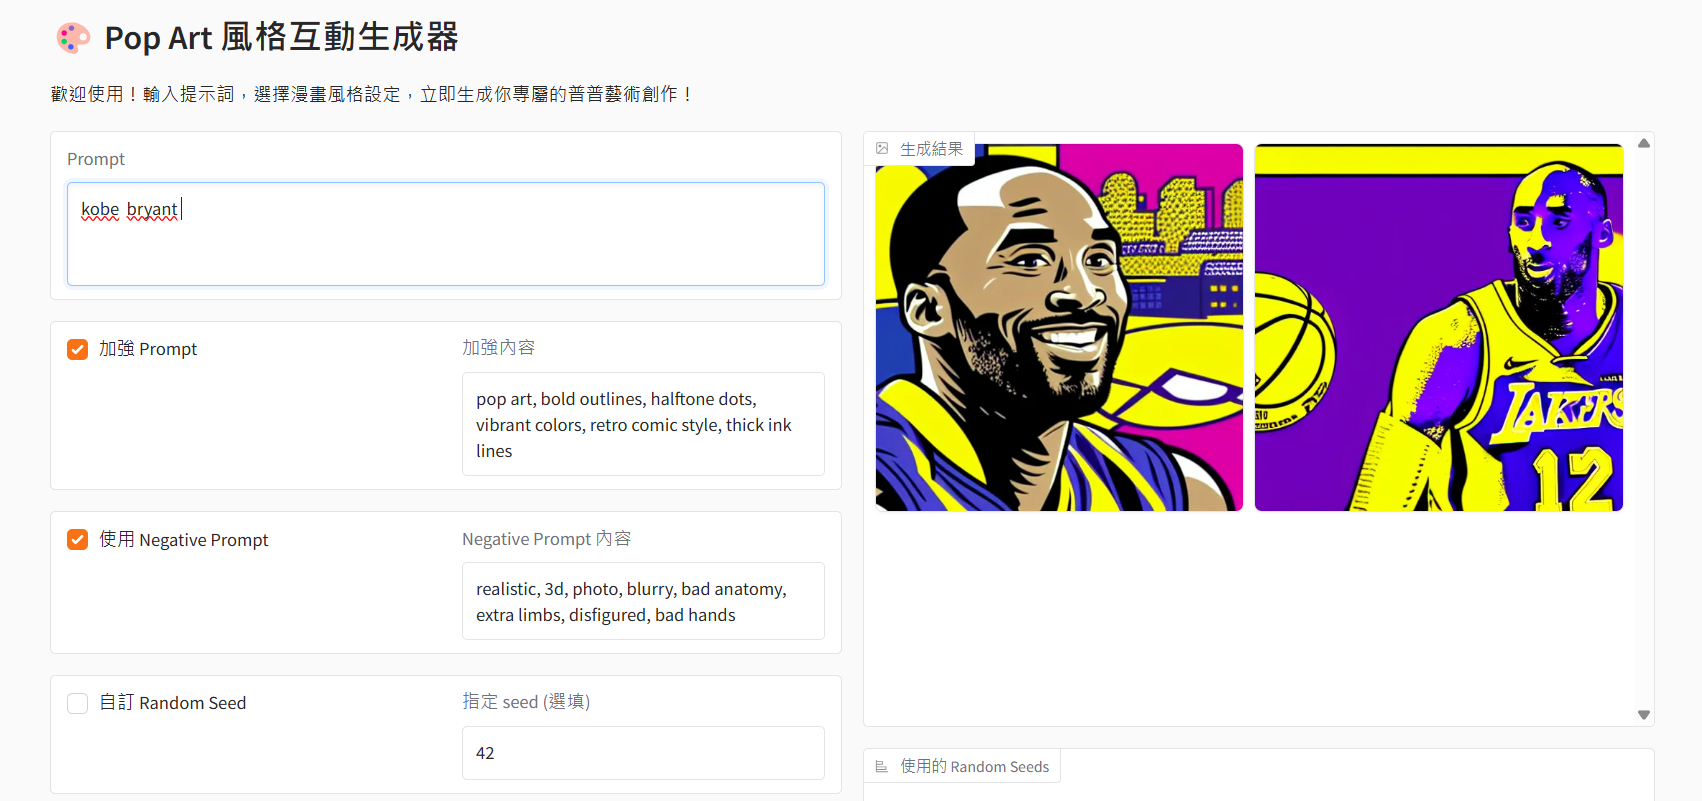
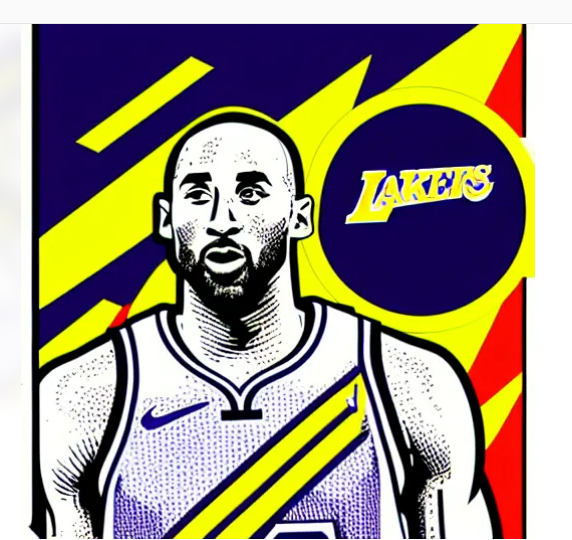

______________________________________________________________________________________________________________
prompt : 大笑的Elon Mask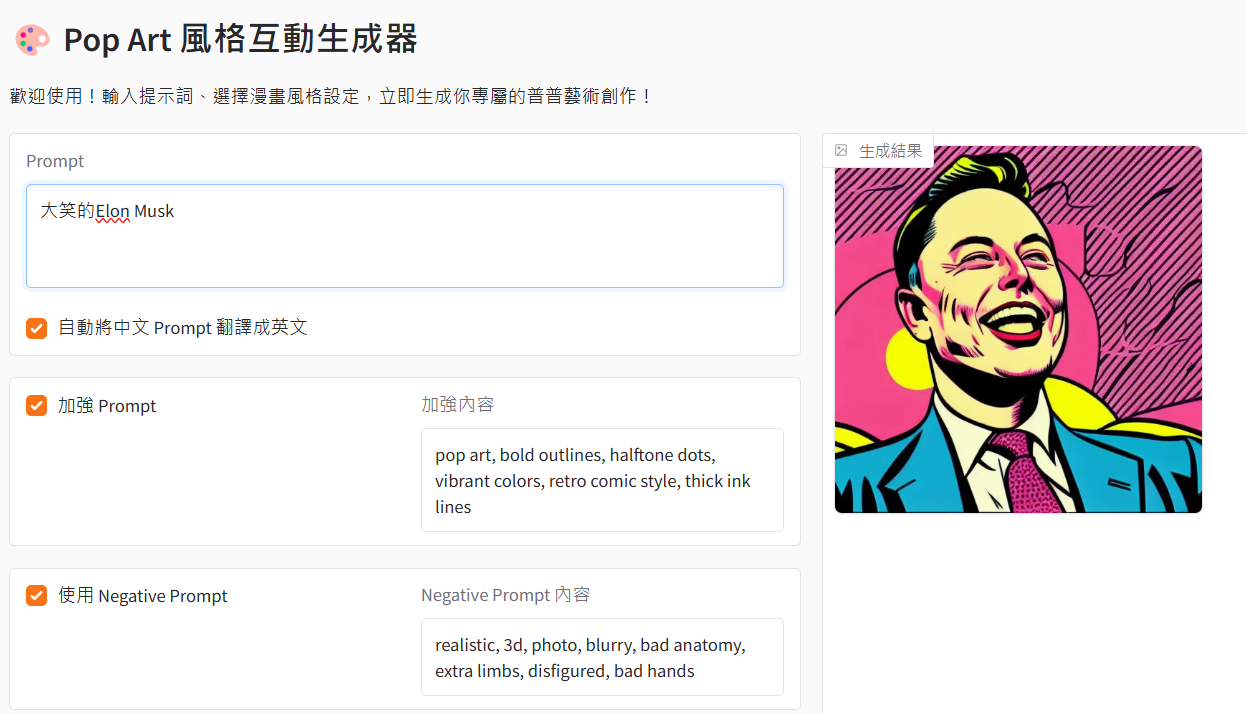

________________________________________________________________________________
prompt : lebron james
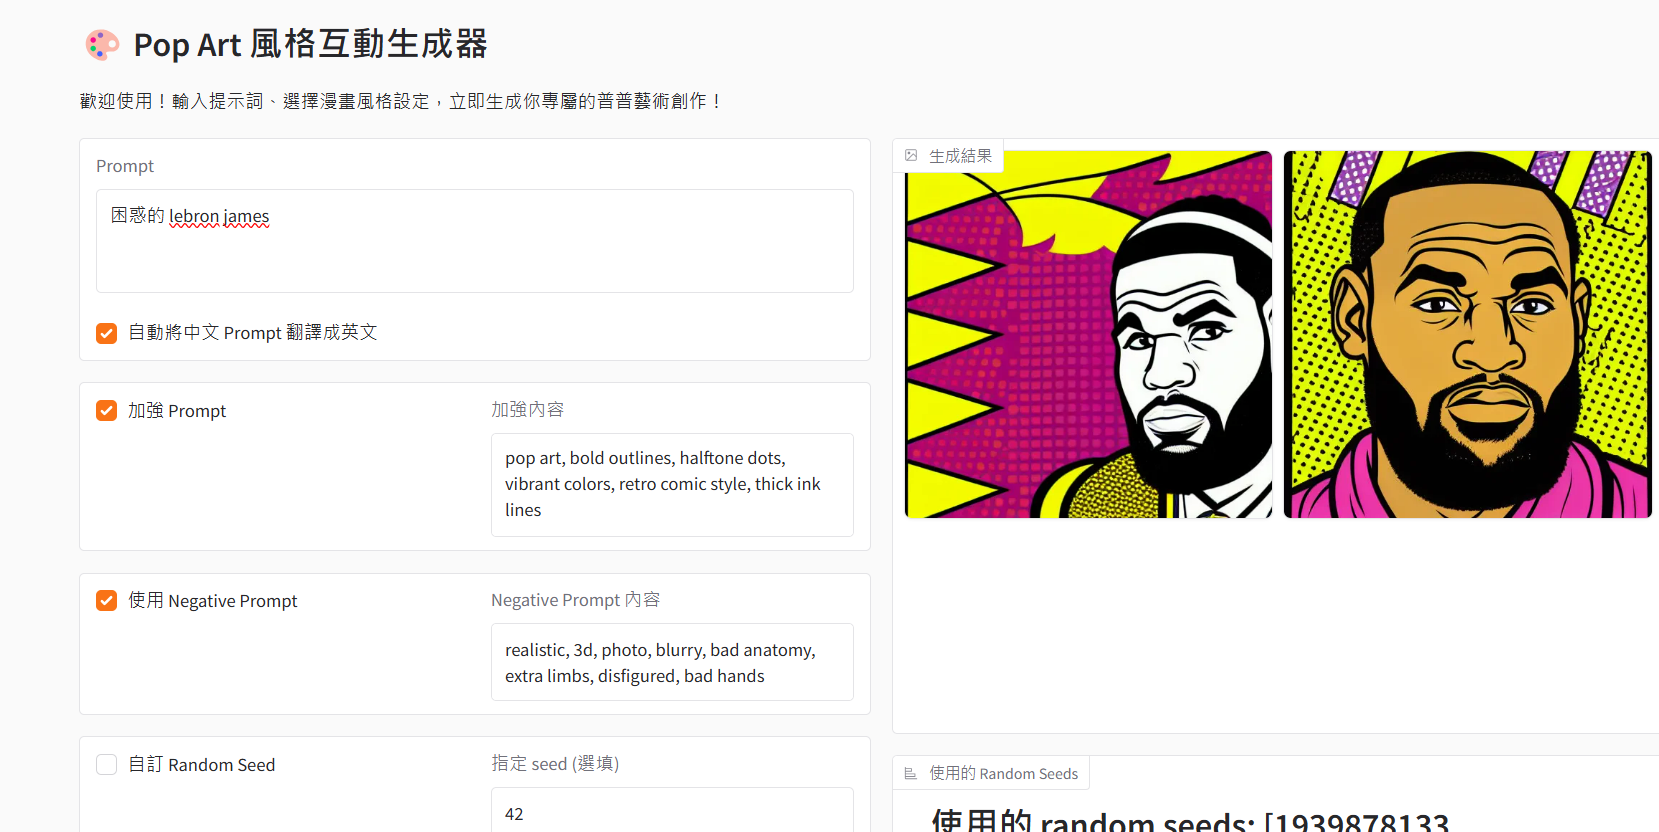

--------------------------------------------------------------------------------
prompt:撫媚的Marilyn Monroe
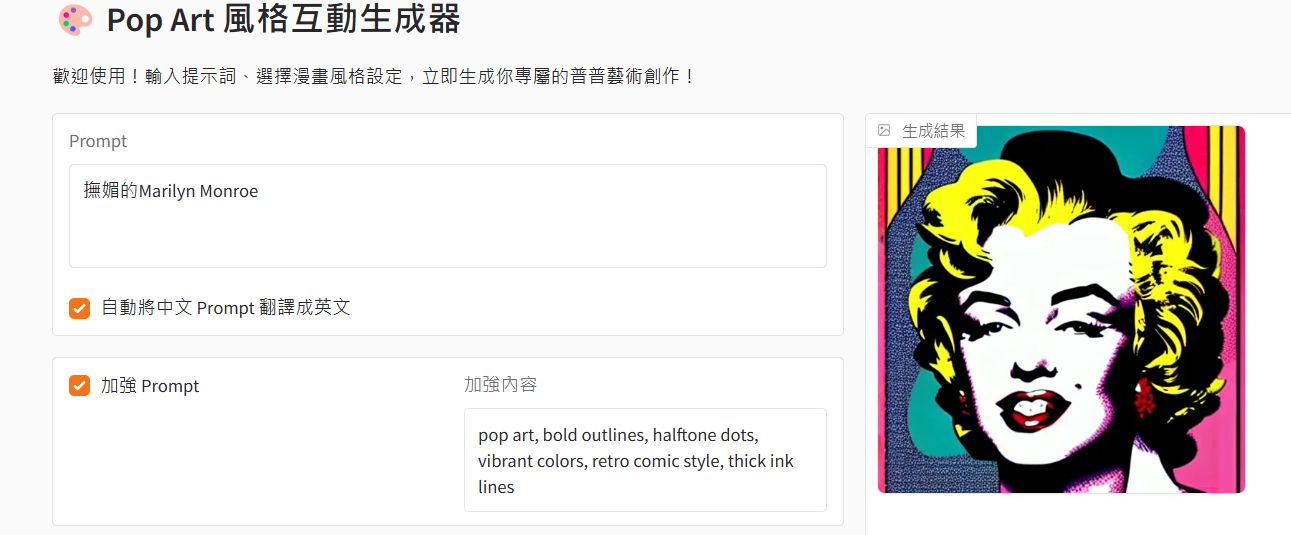

--------------------------------------------------------------------------------
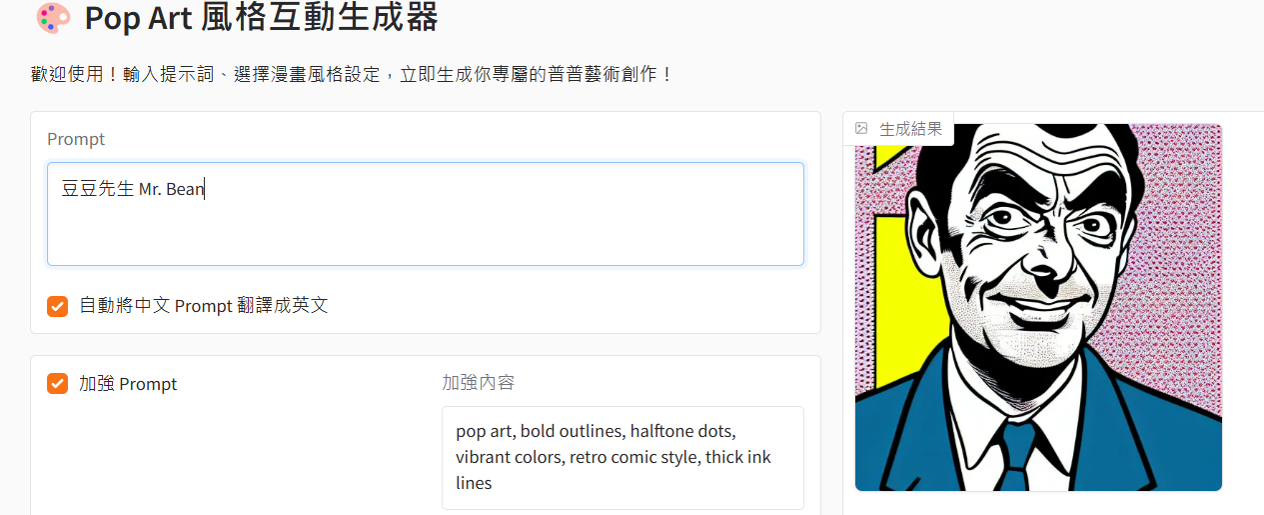

--------------------------------------------------------------------------------
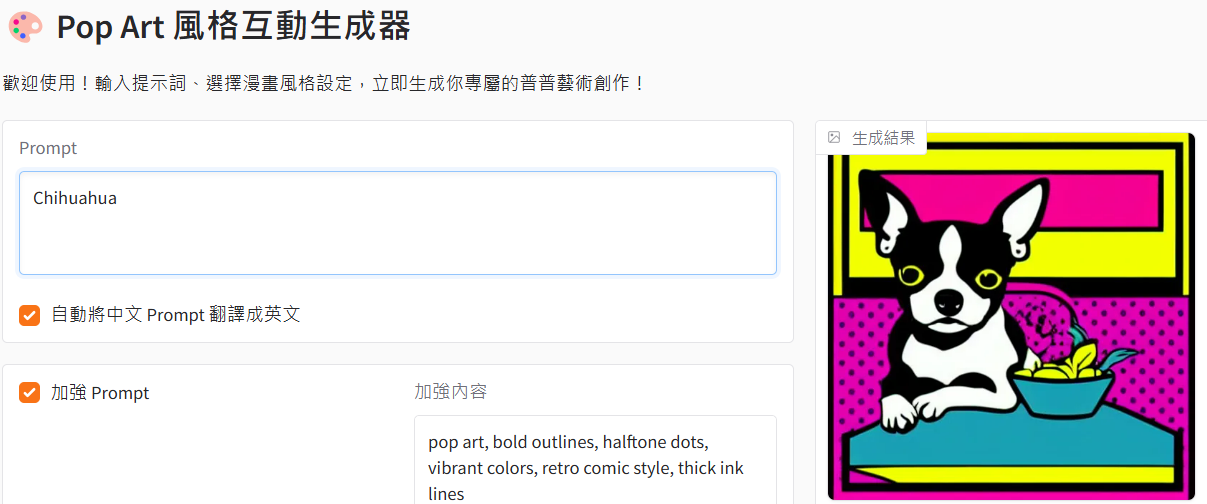

## **程式碼實作：**

# 📚 打造 Stable Diffusion 的 WebUI

### 1. 安裝必要套件

In [ ]:
!pip install deep-translator #安裝翻譯套件

In [ ]:
!pip install diffusers transformers accelerate safetensors huggingface_hub gradio --upgrade

In [ ]:
# from google.colab import userdata

# hf_token = userdata.get("HuggingFace")
# login(token=hf_token)

In [ ]:
from diffusers import StableDiffusionPipeline
from diffusers.utils import load_image
from diffusers import DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from safetensors.torch import load_file
from pathlib import Path

from diffusers import StableDiffusionPipeline, UniPCMultistepScheduler
import torch
import gc
import matplotlib.pyplot as plt
import gradio as gr
import random

### 2. 指定並讀入模型 (**這邊改**)

模仿 Roy Lichtenstein 的普普藝術風格，適合生成具有漫畫風格的人像

In [ ]:
#model_name = "runwayml/stable-diffusion-v1-5"

from diffusers import StableDiffusionPipeline
import torch

model_id = "ItsJayQz/Roy_PopArt_Diffusion"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

prompt = "portrait of a woman, roypop style, digital art, trending on artstation, highly detailed"
image = pipe(prompt).images[0]
image.save("pop_art_portrait.png")

注意有可能要停用 `use_safetensors=True`。

In [ ]:
'''
pipe = StableDiffusionPipeline.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    use_safetensors=True
).to("cuda")
'''

In [ ]:
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

### 3. 生成的函式

In [ ]:
def generate_images(prompt, use_enhance, enhance_text, use_negative, negative_text,
                    use_custom_seed, custom_seed, height, width, steps, num_images):

    height = int(height)
    width = int(width)

    if height % 8 != 0 or width % 8 != 0:
        raise ValueError("高度和寬度必須是8的倍數！")

    if use_custom_seed:
        base_seed = int(custom_seed)
    else:
        base_seed = random.randint(0, 2**32 - 1)

    seeds = [base_seed + i for i in range(num_images)]

    prompts = []
    negative_prompts = []
    generators = []

    final_prompt = prompt
    if use_enhance and enhance_text:
        final_prompt = prompt + ", " + enhance_text

    final_negative = negative_text if use_negative else None

    for seed in seeds:
        g = torch.Generator("cuda").manual_seed(seed)
        generators.append(g)
        prompts.append(final_prompt)
        negative_prompts.append(final_negative)

    gc.collect()
    torch.cuda.empty_cache()

    images = []
    for i in range(num_images):
        with torch.no_grad():
            image = pipe(
                prompt=prompts[i],
                negative_prompt=negative_prompts[i] if final_negative else None,
                height=height,
                width=width,
                num_inference_steps=steps,
                guidance_scale=9.0,
                generator=generators[i]
            ).images[0]
            images.append(image)

    return images, f"使用的 random seeds: {seeds}"

### 4. 打造 Gradio Web App  default_enhance、default_negative可以改


In [ ]:
# ========== 預設值與翻譯工具 ==========
default_enhance = "pop art, bold outlines, halftone dots, vibrant colors, retro comic style, thick ink lines"
default_negative = "realistic, 3d, photo, blurry, bad anatomy, extra limbs, disfigured, bad hands"

from deep_translator import GoogleTranslator

def translate_prompt_if_needed(prompt, auto_translate):
    if auto_translate:
        return GoogleTranslator(source='auto', target='en').translate(prompt)
    return prompt


# ========== 主生成函式 ==========
def generate_images(prompt, use_enhance, enhance_text, use_negative, negative_text,
                    use_custom_seed, custom_seed, height, width, steps, num_images,
                    auto_translate):

    import torch, gc, random

    # 翻譯 prompt（若啟用）
    prompt = translate_prompt_if_needed(prompt, auto_translate)

    height = int(height)
    width = int(width)

    if height % 8 != 0 or width % 8 != 0:
        raise ValueError("高度和寬度必須是8的倍數！")

    base_seed = int(custom_seed) if use_custom_seed else random.randint(0, 2**32 - 1)
    seeds = [base_seed + i for i in range(num_images)]

    final_prompt = prompt + ", " + enhance_text if use_enhance and enhance_text else prompt
    final_negative = negative_text if use_negative else None

    prompts = [final_prompt] * num_images
    negative_prompts = [final_negative] * num_images
    generators = [torch.Generator("cuda").manual_seed(seed) for seed in seeds]

    gc.collect()
    torch.cuda.empty_cache()

    images = []
    for i in range(num_images):
        with torch.no_grad():
            image = pipe(
                prompt=prompts[i],
                negative_prompt=negative_prompts[i],
                height=height,
                width=width,
                num_inference_steps=steps,
                guidance_scale=9.0,  # Pop Art 建議高一點
                generator=generators[i]
            ).images[0]
            images.append(image)

    return images, f"使用的 random seeds: {seeds}"

# ========== Gradio UI ==========
import gradio as gr

with gr.Blocks(css=".gradio-container {background-color: #FAFAFA; padding: 20px;} .gr-button {font-size: 18px; background: linear-gradient(to right, #667eea, #764ba2); color: white;}") as demo:
    gr.Markdown("""
# 🎨 Pop Art 風格互動生成器
歡迎使用！輸入提示詞、選擇漫畫風格設定，立即生成你專屬的普普藝術創作！
""")

    with gr.Row():
        with gr.Column(scale=6):
            prompt = gr.Textbox(label="Prompt", placeholder="例如：kobe bryant", lines=3)
            auto_translate = gr.Checkbox(label="自動將中文 Prompt 翻譯成英文", value=True)
            with gr.Row():
                use_enhance = gr.Checkbox(label="加強 Prompt", value=True)
                enhance_text = gr.Textbox(label="加強內容", value=default_enhance)
            with gr.Row():
                use_negative = gr.Checkbox(label="使用 Negative Prompt", value=True)
                negative_text = gr.Textbox(label="Negative Prompt 內容", value=default_negative)
            with gr.Row():
                use_custom_seed = gr.Checkbox(label="自訂 Random Seed", value=False)
                custom_seed = gr.Number(label="指定 seed (選填)", value=42)
            with gr.Row():
                height = gr.Dropdown(["512", "768", "1024"], label="高度 Height", value="512")
                width = gr.Dropdown(["512", "768", "1024"], label="寬度 Width", value="512")
            with gr.Row():
                steps = gr.Slider(10, 50, value=20, step=5, label="生成步數 (Steps)")
                num_images = gr.Slider(1, 4, step=1, value=1, label="生成張數")
            generate_btn = gr.Button("🚀 開始生成！")

        with gr.Column(scale=6):
            gallery = gr.Gallery(label="生成結果", columns=2, object_fit="contain", height="auto")
            seed_info = gr.Label(label="使用的 Random Seeds")

    generate_btn.click(
        fn=generate_images,
        inputs=[prompt, use_enhance, enhance_text, use_negative, negative_text,
                use_custom_seed, custom_seed, height, width, steps, num_images,
                auto_translate],
        outputs=[gallery, seed_info]
    )

demo.launch()


In [ ]:
demo.launch(share=True, debug=True)